<a href="https://colab.research.google.com/github/VaeriaBautista/Simulaci-n-I/blob/main/5_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#Importamos las sig librerias:
import numpy as np #Para el cálculo numérico
import matplotlib.pyplot as plt  #Para la creación de gráficos y visualizaciones de datos
import pandas as pd #Para trabajar con datos tabulares y series temporales
from scipy import stats #Para realizar análisis estadísticos y trabajar con distribuciones de probabilidad
from scipy.stats import ttest_rel #Para compara las medias de dos grupos relacionados para determinar si existe una diferencia estadísticamente significativa entre ellos.
import seaborn as sns #Para visualizar la distribución de una variable, como histogramas y gráficos de densidad.


In [47]:
# Parámetros del problema
n_demanda = 6          # Parámetro n de la distribución binomial
theta_demanda = 0.5    # Parámetro θ de la distribución binomial
lambda_entrega = 3     # Parámetro λ de la distribución Poisson (tiempo de entrega)

# Costos
costo_mantener = 1     # $1 por unidad por día
costo_faltante = 10    # $10 por unidad faltante
costo_ordenar = 50     # $50 por orden

# Parámetros de las políticas
inventario_objetivo = 30   # Nivel objetivo de inventario
periodo_revision = 8       # Días entre revisiones (Política 1)
punto_reorden = 10         # Punto de reorden (Política 2)

# Parámetros de simulación
dias_simulacion = 1000     # Número de días a simular
num_simulaciones = 100     # Número de simulaciones para obtener estadísticas

print(f"Demanda diaria: Binomial(n={n_demanda}, θ={theta_demanda})")
print(f"Tiempo de entrega: Poisson(λ={lambda_entrega})")
print(f"Costos: Mantener=${costo_mantener}/día, Faltante=${costo_faltante}/unidad, Ordenar=${costo_ordenar}/orden")
print(f"Política 1: Revisar cada {periodo_revision} días, ordenar hasta {inventario_objetivo}")
print(f"Política 2: Ordenar hasta {inventario_objetivo} cuando inventario ≤ {punto_reorden}")


Demanda diaria: Binomial(n=6, θ=0.5)
Tiempo de entrega: Poisson(λ=3)
Costos: Mantener=$1/día, Faltante=$10/unidad, Ordenar=$50/orden
Política 1: Revisar cada 8 días, ordenar hasta 30
Política 2: Ordenar hasta 30 cuando inventario ≤ 10


In [48]:
def generar_demanda(dias):
    """Genera demanda diaria según distribución binomial"""
    return np.random.binomial(n_demanda, theta_demanda, dias)

def generar_tiempo_entrega():
    """Genera tiempo de entrega según distribución Poisson"""
    return np.random.poisson(lambda_entrega)


In [49]:
#IMPLEMENTACIÓN DE LA POLÍTICA 1 (Revisar cada 8 días)
def simular_politica_1(dias):

    #Política 1: Revisar cada 8 días y ordenar hasta 30 unidades

    inventario = inventario_objetivo  # Comenzar con inventario lleno
    costo_total = 0
    ordenes_pendientes = []  # Lista de (día_llegada, cantidad)

    # Registros para análisis
    registro_inventario = []
    registro_faltantes = []
    registro_ordenes = []

    for dia in range(dias):
        # Procesar llegadas de órdenes
        ordenes_llegadas = [orden for orden in ordenes_pendientes if orden[0] == dia]
        for _, cantidad in ordenes_llegadas:
            inventario += cantidad
        ordenes_pendientes = [orden for orden in ordenes_pendientes if orden[0] != dia]

        # Generar demanda del día
        demanda = np.random.binomial(n_demanda, theta_demanda)

        # Satisfacer demanda
        if inventario >= demanda:
            inventario -= demanda
            faltantes = 0
        else:
            faltantes = demanda - inventario
            inventario = 0

        # Calcular costos del día
        costo_mantener_dia = inventario * costo_mantener
        costo_faltante_dia = faltantes * costo_faltante
        costo_total += costo_mantener_dia + costo_faltante_dia

        # Revisar si es día de revisión (cada 8 días)
        if (dia + 1) % periodo_revision == 0:
            # Calcular inventario disponible + en tránsito
            inventario_en_transito = sum([cantidad for _, cantidad in ordenes_pendientes])
            inventario_total = inventario + inventario_en_transito

            if inventario_total < inventario_objetivo:
                cantidad_ordenar = inventario_objetivo - inventario_total
                tiempo_entrega = generar_tiempo_entrega()
                dia_llegada = dia + tiempo_entrega + 1
                ordenes_pendientes.append((dia_llegada, cantidad_ordenar))
                costo_total += costo_ordenar
                registro_ordenes.append((dia, cantidad_ordenar, tiempo_entrega))

        # Registrar datos
        registro_inventario.append(inventario)
        registro_faltantes.append(faltantes)

    return costo_total, registro_inventario, registro_faltantes, registro_ordenes

In [50]:
#IMPLEMENTACIÓN DE LA POLÍTICA 2 (Punto de reorden)
def simular_politica_2(dias):
    """
    Política 2: Ordenar hasta 30 cuando inventario ≤ 10
    """
    inventario = inventario_objetivo
    costo_total = 0
    ordenes_pendientes = []

    # Registros para análisis
    registro_inventario = []
    registro_faltantes = []
    registro_ordenes = []

    for dia in range(dias):
        # Procesar llegadas de órdenes
        ordenes_llegadas = [orden for orden in ordenes_pendientes if orden[0] == dia]
        for _, cantidad in ordenes_llegadas:
            inventario += cantidad
        ordenes_pendientes = [orden for orden in ordenes_pendientes if orden[0] != dia]

        # Generar demanda del día
        demanda = np.random.binomial(n_demanda, theta_demanda)

        # Satisfacer demanda
        if inventario >= demanda:
            inventario -= demanda
            faltantes = 0
        else:
            faltantes = demanda - inventario
            inventario = 0

        # Calcular costos del día
        costo_mantener_dia = inventario * costo_mantener
        costo_faltante_dia = faltantes * costo_faltante
        costo_total += costo_mantener_dia + costo_faltante_dia

        # Revisar si necesita ordenar
        if inventario <= punto_reorden:
            # Verificar que no haya órdenes pendientes
            if not ordenes_pendientes:
                cantidad_ordenar = inventario_objetivo - inventario
                tiempo_entrega = generar_tiempo_entrega()
                dia_llegada = dia + tiempo_entrega + 1
                ordenes_pendientes.append((dia_llegada, cantidad_ordenar))
                costo_total += costo_ordenar
                registro_ordenes.append((dia, cantidad_ordenar, tiempo_entrega))

        # Registrar datos
        registro_inventario.append(inventario)
        registro_faltantes.append(faltantes)

    return costo_total, registro_inventario, registro_faltantes, registro_ordenes

In [51]:
print("\nEjecutando simulaciones...")

costos_politica_1 = []
costos_politica_2 = []

for sim in range(num_simulaciones):
    if (sim + 1) % 20 == 0:
        print(f"Simulación {sim + 1}/{num_simulaciones}")

    # Política 1
    costo_1, _, _, _ = simular_politica_1(dias_simulacion)
    costos_politica_1.append(costo_1)

    # Política 2
    costo_2, _, _, _ = simular_politica_2(dias_simulacion)
    costos_politica_2.append(costo_2)

print("Simulaciones completadas")


Ejecutando simulaciones...
Simulación 20/100
Simulación 40/100
Simulación 60/100
Simulación 80/100
Simulación 100/100
Simulaciones completadas


In [52]:
print("\n=== RESULTADOS DE LA SIMULACIÓN ===")
print(f"Número de simulaciones: {num_simulaciones}")
print(f"Días por simulación: {dias_simulacion}")
print()

print("POLÍTICA 1 (Revisar cada 8 días):")
print(f"  Costo promedio: ${np.mean(costos_politica_1):.2f}")
print(f"  Desviación estándar: ${np.std(costos_politica_1):.2f}")
print(f"  Costo mínimo: ${np.min(costos_politica_1):.2f}")
print(f"  Costo máximo: ${np.max(costos_politica_1):.2f}")
print()

print("POLÍTICA 2 (Punto de reorden ≤ 10):")
print(f"  Costo promedio: ${np.mean(costos_politica_2):.2f}")
print(f"  Desviación estándar: ${np.std(costos_politica_2):.2f}")
print(f"  Costo mínimo: ${np.min(costos_politica_2):.2f}")
print(f"  Costo máximo: ${np.max(costos_politica_2):.2f}")
print()

# Determinar cuál política es mejor
diferencia_promedio = np.mean(costos_politica_1) - np.mean(costos_politica_2)
mejor_politica = "Política 1" if diferencia_promedio < 0 else "Política 2"
ahorro_promedio = abs(diferencia_promedio)

print("=== CONCLUSIÓN ===")
print(f"La {mejor_politica} es más económica")
print(f"Ahorro promedio: ${ahorro_promedio:.2f} ({ahorro_promedio/max(np.mean(costos_politica_1), np.mean(costos_politica_2))*100:.2f}%)")
print()

# Test estadístico
t_stat, p_value = ttest_rel(costos_politica_1, costos_politica_2)
print(f"Test t pareado:")
print(f"  Estadístico t: {t_stat:.4f}")
print(f"  Valor p: {p_value:.6f}")
print(f"  Diferencia estadísticamente significativa: {'Sí' if p_value < 0.05 else 'No'}")


=== RESULTADOS DE LA SIMULACIÓN ===
Número de simulaciones: 100
Días por simulación: 1000

POLÍTICA 1 (Revisar cada 8 días):
  Costo promedio: $20617.49
  Desviación estándar: $309.96
  Costo mínimo: $19943.00
  Costo máximo: $21379.00

POLÍTICA 2 (Punto de reorden ≤ 10):
  Costo promedio: $19764.36
  Desviación estándar: $245.41
  Costo mínimo: $19166.00
  Costo máximo: $20444.00

=== CONCLUSIÓN ===
La Política 2 es más económica
Ahorro promedio: $853.13 (4.14%)

Test t pareado:
  Estadístico t: 19.5710
  Valor p: 0.000000
  Diferencia estadísticamente significativa: Sí


In [53]:
# Ejecutar una simulación para obtener datos detallados necesarios para las gráficas
costo_1_det, inv_1, falt_1, ord_1 = simular_politica_1(365)
costo_2_det, inv_2, falt_2, ord_2 = simular_politica_2(365)

# Calcular componentes de costo para las gráficas
mant_1 = sum(inv_1) * costo_mantener
falt_1_costo = sum(falt_1) * costo_faltante
ord_1_costo = len(ord_1) * costo_ordenar

mant_2 = sum(inv_2) * costo_mantener
falt_2_costo = sum(falt_2) * costo_faltante
ord_2_costo = len(ord_2) * costo_ordenar

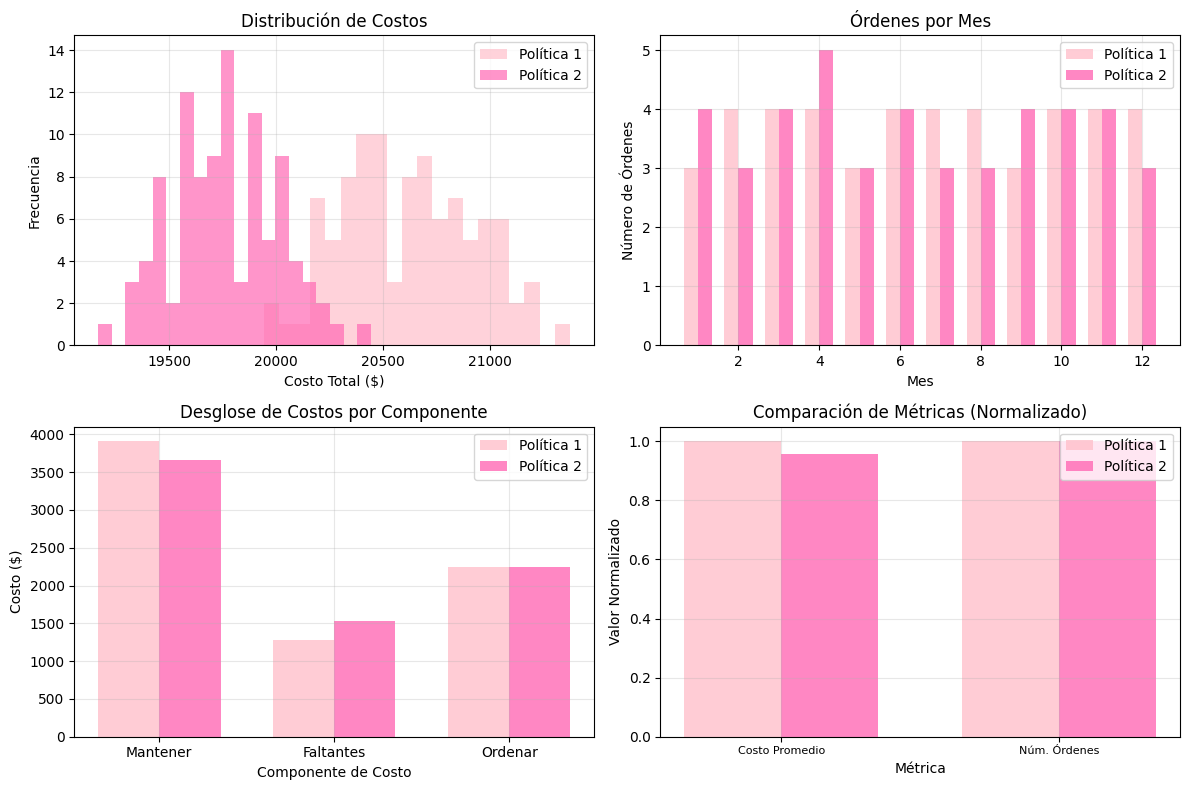

In [64]:
plt.figure(figsize=(12, 8))

# Gráfico 1: Histograma de costos
plt.subplot(2, 2, 1)
plt.hist(costos_politica_1, alpha=0.7, label='Política 1', bins=20, color='pink')
plt.hist(costos_politica_2, alpha=0.7, label='Política 2', bins=20, color='hotpink')
plt.xlabel('Costo Total ($)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Costos')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Número de órdenes por mes
plt.subplot(2, 2, 2)
# Contar órdenes por mes
ordenes_mes_1 = [0] * 12
ordenes_mes_2 = [0] * 12

for dia, _, _ in ord_1:
    mes = dia // 30
    if mes < 12:
        ordenes_mes_1[mes] += 1

for dia, _, _ in ord_2:
    mes = dia // 30
    if mes < 12:
        ordenes_mes_2[mes] += 1

meses = range(1, 13)
width = 0.35
plt.bar([m - width/2 for m in meses], ordenes_mes_1, width, label='Política 1', alpha=0.8, color='pink')
plt.bar([m + width/2 for m in meses], ordenes_mes_2, width, label='Política 2', alpha=0.8, color='hotpink')
plt.xlabel('Mes')
plt.ylabel('Número de Órdenes')
plt.title('Órdenes por Mes')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Comparación de costos promedio por componente
plt.subplot(2, 2, 3)
componentes = ['Mantener', 'Faltantes', 'Ordenar']
costos_p1 = [mant_1, falt_1_costo, ord_1_costo]
costos_p2 = [mant_2, falt_2_costo, ord_2_costo]

x = np.arange(len(componentes))
width = 0.35

plt.bar(x - width/2, costos_p1, width, label='Política 1', alpha=0.8, color='pink')
plt.bar(x + width/2, costos_p2, width, label='Política 2', alpha=0.8, color='hotpink')

plt.xlabel('Componente de Costo')
plt.ylabel('Costo ($)')
plt.title('Desglose de Costos por Componente')
plt.xticks(x, componentes)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 4: Resumen estadístico
plt.subplot(2, 2, 4)
datos_resumen = {
    'Política 1': [np.mean(costos_politica_1), len(ord_1)],
    'Política 2': [np.mean(costos_politica_2), len(ord_2)]
}
metricas = ['Costo Promedio', 'Núm. Órdenes']

x = np.arange(len(metricas))
# Normalizar valores para visualización
datos_norm_p1 = [datos_resumen['Política 1'][i] / max(datos_resumen['Política 1'][i], datos_resumen['Política 2'][i]) for i in range(2)]
datos_norm_p2 = [datos_resumen['Política 2'][i] / max(datos_resumen['Política 1'][i], datos_resumen['Política 2'][i]) for i in range(2)]

plt.bar(x - width/2, datos_norm_p1, width, label='Política 1', alpha=0.8, color='pink')
plt.bar(x + width/2, datos_norm_p2, width, label='Política 2', alpha=0.8, color='hotpink')

plt.xlabel('Métrica')
plt.ylabel('Valor Normalizado')
plt.title('Comparación de Métricas (Normalizado)')
plt.xticks(x, metricas, rotation=0, fontsize=8)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [55]:
data_resumen = {
    'Métrica': ['Costo Promedio', 'Desviación Estándar'],
    'Política 1': [f"${np.mean(costos_politica_1):.2f}", f"${np.std(costos_politica_1):.2f}"],
    'Política 2': [f"${np.mean(costos_politica_2):.2f}", f"${np.std(costos_politica_2):.2f}"]
}

df_resumen = pd.DataFrame(data_resumen)
print("\n=== TABLA RESUMEN ===")
print(df_resumen.to_string(index=False))

print(f"\n=== RESPUESTA FINAL ===")
print(f"Basado en {num_simulaciones} simulaciones de {dias_simulacion} días cada una:")
print(f"La {mejor_politica} es más económica con un ahorro promedio de ${ahorro_promedio:.2f}")
if p_value < 0.05:
    print("Esta diferencia es estadísticamente significativa (p < 0.05)")
else:
    print("Esta diferencia no es estadísticamente significativa (p ≥ 0.05)")

print("\n=== SIMULACIÓN COMPLETADA ===")


=== TABLA RESUMEN ===
            Métrica Política 1 Política 2
     Costo Promedio  $20617.49  $19764.36
Desviación Estándar    $309.96    $245.41

=== RESPUESTA FINAL ===
Basado en 100 simulaciones de 1000 días cada una:
La Política 2 es más económica con un ahorro promedio de $853.13
Esta diferencia es estadísticamente significativa (p < 0.05)

=== SIMULACIÓN COMPLETADA ===
